In [1]:
import matplotlib.pyplot as plt

import numpy as np


from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset
from l5kit.geometry.transform import *

from l5kit.rasterization import build_rasterizer
from l5kit.configs import load_config_data
from l5kit.geometry import transform_points, rotation33_as_yaw
from tqdm import tqdm
from collections import Counter
from l5kit.rasterization.rasterizer_builder import _load_metadata
from prettytable import PrettyTable

import os

# from l5kit.visualization.visualizer.zarr_utils import zarr_to_visualizer_scene
# from l5kit.visualization.visualizer.visualizer import visualize
from bokeh.io import output_notebook, show
from l5kit.data import MapAPI
from IPython.display import display, clear_output
import PIL

from scenario import get_lanes, lane_check, current_lane


import matlab
import matlab.engine

# eng = matlab.engine.start_matlab()

D:\Anaconda\lib\site-packages\l5kit\dataset\select_agents.py:31: UserWarning: Windows detected. BLOSC_NOLOCK has not been set as it causes memory leaks on Windows.However, writing the mask with this config may be inconsistent.
  "Windows detected. BLOSC_NOLOCK has not been set as it causes memory leaks on Windows."


In [2]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "C:\\Users\\zheng\\Desktop\\UMich\\Independent Study\\prediction-dataset"
# get config
cfg = load_config_data("C:\\Users\\zheng\\Desktop\\UMich\\Independent Study\\Codes\\python codes\\visualisation_config.yaml")
print(cfg)

dm = LocalDataManager()
dataset_path = dm.require(cfg["val_data_loader"]["key"])
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()
print(zarr_dataset)

rast = build_rasterizer(cfg, dm)
ego_dataset = EgoDataset(cfg, zarr_dataset, rast)
# agent_dataset = AgentDataset(cfg, zarr_dataset, rast)
# Obatin the information from semantic map

semantic_map_filepath = dm.require(cfg["raster_params"]["semantic_map_key"])
dataset_meta = _load_metadata(cfg["raster_params"]["dataset_meta_key"], dm)
world_to_ecef = np.array(dataset_meta["world_to_ecef"], dtype=np.float64)
Map_Api = MapAPI(semantic_map_filepath, world_to_ecef)

# Load all lane information into one dictionary
all_lanes = get_lanes(Map_Api)
Lane = {Map_Api.id_as_str(lane.id):lane.element.lane for lane in all_lanes}

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 0, 'future_num_frames': 50, 'step_time': 0.1}, 'raster_params': {'raster_size': [320, 320], 'pixel_size': [0.5, 0.5], 'ego_center': [0.6, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False, 'set_origin_to_bottom': True}, 'val_data_loader': {'key': 'scenes/train.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 16}}
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+------

## Now check the lane-junction relation

In [6]:
# first find all junctions and then find the corresponding scene by matching the lane information
def is_junction(elem, map_api):
    return elem.element.HasField("junction")

def get_junctions(map_api):
    return [elem for elem in map_api.elements if is_junction(elem, map_api)]

all_junctions = get_junctions(Map_Api)

In [225]:
# define the function which finds the passing lanes when AV was making a turn

def turning_lanes():
    
    frames = list(range(zarr_dataset.scenes[scene]["frame_index_interval"][0],zarr_dataset.scenes[scene]["frame_index_interval"][1]))
    yaw = [rotation33_as_yaw(rotation) for rotation in zarr_dataset.frames['ego_rotation'][frames]]
    turning_frame = turning_frame(yaw, eng)
    lanes = []



    for frame in tqdm(turning_frame):
        lanes.append(current_lane(zarr_dataset.frames[frame]['ego_translation'][:2], Lane, Map_Api))

    lanes = set(lanes)
    
    return lanes

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.13it/s]


In [226]:
# Now define the function which generates Junction-Lane dictionary

def Junctiion_lane():
    Junction_Lane = {}

    for junction in all_junctions:

        Junction_Lane[Map_Api.id_as_str(junction.id)] = []

        for lane in junction.element.junction.lanes:
            Junction_Lane[Map_Api.id_as_str(junction.id)].append(Map_Api.id_as_str(lane))

        Junction_Lane[Map_Api.id_as_str(junction.id)] = set(Junction_Lane[Map_Api.id_as_str(junction.id)])
    
    
    
# define the function which finds the corresponding intersection containing the passing lanes

def junction_id_find():
    junction_id = []

    for key in Junction_Lane.keys():

        if len(Junction_Lane[key]&lanes) != 0:
            junction_id.append(key)
            
            
# define the function which classify the scenes into junction group

def junction_scene(self, scene_idx, junction_id):
    
    self.junction_scene[junction_id] += [scene_idx]


In [35]:
class Scene(object):
    def __init__(self, dataset):
        self.dataset = dataset
        self.frames = self.dataset.frames
        self.scene_num = len(self.dataset.scenes)
        self.yaw_th = 1
        self.distance_th = 10
        self.eng = matlab.engine.start_matlab()
        self.eng.cd(r'D:\GitHub\Clone\planning\utils') 
        self.turning_scenes = []
        self.tunring_frames = []
        
        
    def trajectory_visualize(self, turning_frames):
        plt.figure(figsize=(18,18))
        plt.scatter(self.frames["ego_translation"][:,0], self.frames["ego_translation"][:,1], marker='.')
        plt.scatter(self.frames["ego_translation"][self.tunring_frames,0], self.frames["ego_translation"][self.tunring_frames,1], marker='.', color='r')
        plt.axis("equal")
        plt.grid(which='both')
        axes = plt.gca()
        
        
        
    def turning_scenes_finding(self):
        
        for scene in tqdm(range(self.scene_num)):

            start_frame = self.frames[self.dataset.scenes[scene]["frame_index_interval"][0]]
            finish_frame = self.frames[self.dataset.scenes[scene]["frame_index_interval"][1]-1]

            start_yaw = rotation33_as_yaw(start_frame["ego_rotation"])
            finish_yaw = rotation33_as_yaw(finish_frame["ego_rotation"])


            if abs(start_yaw-finish_yaw) > self.yaw_th:
                self.turning_scenes.append(scene)
                self.tunring_frames += list(range(self.dataset.scenes[scene]["frame_index_interval"][0],self.dataset.scenes[scene]["frame_index_interval"][1]))
                
    
    def scene_visualize(self, scene_idx):
        
        indexes = ego_dataset.get_scene_indices(scene_idx)
        images = []

        for idx in indexes:

            data = ego_dataset[idx]
            im = data["image"].transpose(1, 2, 0)
            im = ego_dataset.rasterizer.to_rgb(im)
            target_positions_pixels = transform_points(data["target_positions"], data["raster_from_agent"])
            center_in_pixels = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
        #     draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, yaws=data["target_yaws"])
            clear_output(wait=True)
            display(PIL.Image.fromarray(im))
            
            
    
    def chgpt_index_find(self, chgpt_loc, chgpt_dist, chgpt_num):
        rel_d = np.diff(chgpt_loc)
        
        while True in (rel_d < self.distance_th):
            for idx, d in enumerate(rel_d):
                if d < self.distance_th:
                    index = chgpt_loc[idx] if chgpt_dist[chgpt_loc[idx]]< chgpt_dist[chgpt_loc[idx+1]] else chgpt_loc[idx+1]
                    chgpt_dist[index] = 0
            chgpt_loc = np.argpartition(chgpt_dist, -chgpt_num)[-chgpt_num:]
            chgpt_loc.sort()
            # find the adjacent distance
            rel_d = np.diff(chgpt_loc)
            
            
        return chgpt_loc

    
            
    def scene_turning_frames(self, scene_idx):
        
        frames = list(range(self.dataset.scenes[scene_idx]["frame_index_interval"][0],self.dataset.scenes[scene_idx]["frame_index_interval"][1]))
        yaw = [rotation33_as_yaw(rotation) for rotation in self.dataset.frames['ego_rotation'][frames]]
        
        # extract key info from MATLAB results
        output_yaw = self.eng.mat2py(matlab.double(yaw), nargout=2)

        chgpt_dist_yaw = np.array(output_yaw[0])[0]
        chgpt_num_dist_yaw = np.array(output_yaw[1]).flatten()

        chgpt_num = np.argmax(chgpt_num_dist_yaw)
        chgpt_index = np.argpartition(chgpt_dist_yaw, -chgpt_num)[-chgpt_num:]
        chgpt_index.sort()
        
        chgpt_loc = self.chgpt_index_find(chgpt_index, chgpt_dist_yaw, chgpt_num)



        return list(range(chgpt_loc[0],chgpt_loc[1]))
    
    
    
    
    def 

In [37]:
a.turning_scenes_finding()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16265/16265 [00:32<00:00, 507.87it/s]


In [38]:
a.scene_turning_frames(8)

[32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66]

In [36]:
a = Scene(zarr_dataset)

In [40]:
frames = list(range(zarr_dataset.scenes[8]["frame_index_interval"][0],zarr_dataset.scenes[8]["frame_index_interval"][1]))

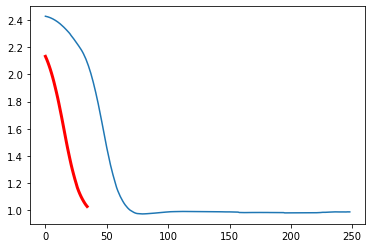

In [41]:
yaw = [rotation33_as_yaw(rotation) for rotation in zarr_dataset.frames['ego_rotation'][frames]]
plt.plot(range(len(yaw)),yaw)
plt.plot(range(len(yaw[32:67])),yaw[32:67],color='r',linewidth=3)

In [30]:
eng = matlab.engine.start_matlab()
eng.cd(r'D:\GitHub\Clone\planning\utils')

'D:\\GitHub\\Clone\\planning'

In [37]:
chgpt_num_dist_yaw

array([2.19926254e-302, 4.87629129e-020, 1.00000000e+000])

In [38]:
output_yaw = eng.mat2py(matlab.double(yaw), nargout=2)

chgpt_dist_yaw = np.array(output_yaw[0])[0]
chgpt_num_dist_yaw = np.array(output_yaw[1]).flatten()

chgpt_num = np.argmax(chgpt_num_dist_yaw)
chgpt_index = np.argpartition(chgpt_dist_yaw, -chgpt_num)[-chgpt_num:]
chgpt_index.sort()

In [40]:
chgpt_dist_yaw

array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e-04, 4.000e-04,
       1.600e-03, 3.600e-03, 1.180e-02, 3.160e-02, 5.760e-02, 8.880e-02,
       1.248e-01, 1.380e-01, 1.408e-01, 1.338e-01, 1.072e-01, 8.020e-02,
       4.960e-02, 1.760e-02, 9.600e-03, 2.200e-03, 6.000e-04, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.500e-02,
       3.184e-01, 5.122e-01, 1.426e-01, 1.140e-02, 4.000e-04, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 